# Periodic Table of Uiua

I am having trouble styling the glyphs to match the site. I actually think we
might be able to do better. Currently the coloring encodes the type of function
(ie Modifier/Stack etc) and some information about number of input arguments.

From my inspection so far I don't see that the coloring encodes number of output
arguments. I don't think its possible to encode everything in colour and layout
alone. But with a periodic table thing... maybe?

## Match Uiua Website

The first thing is to try match the uiua web editor colors, then we can try get fancy later.

In [12]:
import pandas as pd
import json
from pathlib import Path

In [13]:
import re
def strip_js(js_text:str)->str:
    """keep everything between the first `[` and last `]` inclusive"""
    result = re.search(
        pattern = r"\[.*\]",
        string  = js_text,
        flags   = re.DOTALL
    )
    return result.group(0) if result else ""

def read_js_json(file_path:str):
    return json.loads(strip_js(
        Path(file_path).read_text()
    ))

In [14]:
df = pd.DataFrame.from_records(
    [
        *read_js_json("./webview_keypad/primitives.js"),
        *read_js_json("./webview_keypad/extra_primitives.js"),
    ]
)
df

,name,description,glyph,count_inputs,count_outputs,count_modifier_inputs,primitive_class,docs
0,duplicate,Duplicate the top value on the stack,.,1.0,2.0,NaN,Stack,NaN
1,over,Duplicate the second-to-top value to the top o...,",",2.0,3.0,NaN,Stack,NaN
2,flip,Swap the top two values on the stack,∶,2.0,2.0,NaN,Stack,NaN
3,pop,Discard the top stack value,;,1.0,0.0,NaN,Stack,NaN
4,identity,Do nothing,∘,1.0,1.0,NaN,Planet,NaN
...,...,...,...,...,...,...,...,...
158,String Delimiter,,"""",NaN,NaN,NaN,Syntax,types#characters
159,Placeholder,,^,NaN,NaN,NaN,Syntax,custommodifiers
160,Binding,Gives a global name a value,←,NaN,NaN,NaN,Syntax,bindings
161,signature / terminator,,|,NaN,NaN,NaN,Syntax,functions#stack-signatures


In [15]:
df['primitive_class'].unique()

array(['Stack', 'Planet', 'MonadicPervasive', 'DyadicPervasive',
       'MonadicArray', 'DyadicArray', 'AggregatingModifier',
       'IteratingModifier', 'OtherModifier', 'Ocean', 'Control', 'Misc',
       'Constant', 'Sys', 'Syntax'], dtype=object)

In [18]:
existing_map = {
    "stack-function"   : "#d1daec",
    "noadic-function"  : "#ed5e6a",
    "monadic-function" : "#95d16a",
    "dyadic-function"  : "#54b0fc",
    "monadic-modifier" : "#f0c36f",
    "dyadic-modifier"  : "#cc6be9",
    "ocean-function"   : "#03d7d9",
}
new_map = {
    'Stack'                : existing_map["stack-function"],
    'Planet'               : existing_map["monadic-modifier"],
    'MonadicPervasive'     : existing_map["monadic-function"],
    'MonadicArray'         : existing_map["monadic-function"],
    'DyadicPervasive'      : existing_map["dyadic-function"],
    'DyadicArray'          : existing_map["dyadic-function"],
    'AggregatingModifier'  : existing_map["monadic-modifier"],
    'IteratingModifier'    : existing_map["monadic-modifier"],
    'OtherModifier'        : existing_map["monadic-modifier"],
    'Ocean'                : existing_map["ocean-function"],
    'Control'              : existing_map["dyadic-modifier"],
    'Misc'                 : "paleyellow",
    'Constant'             : "brown",
    'Sys'                  : "palegreen",
    'Syntax'               : "#888",
}
df["color_foreground"] = df["primitive_class"].map(new_map)
df["pervasive"] = df.primitive_class.str.contains("Pervasive").map({True:"∀", False:""})
df["modifier"] = df.primitive_class.str.contains("Modifier").map({True:"M", False:""})

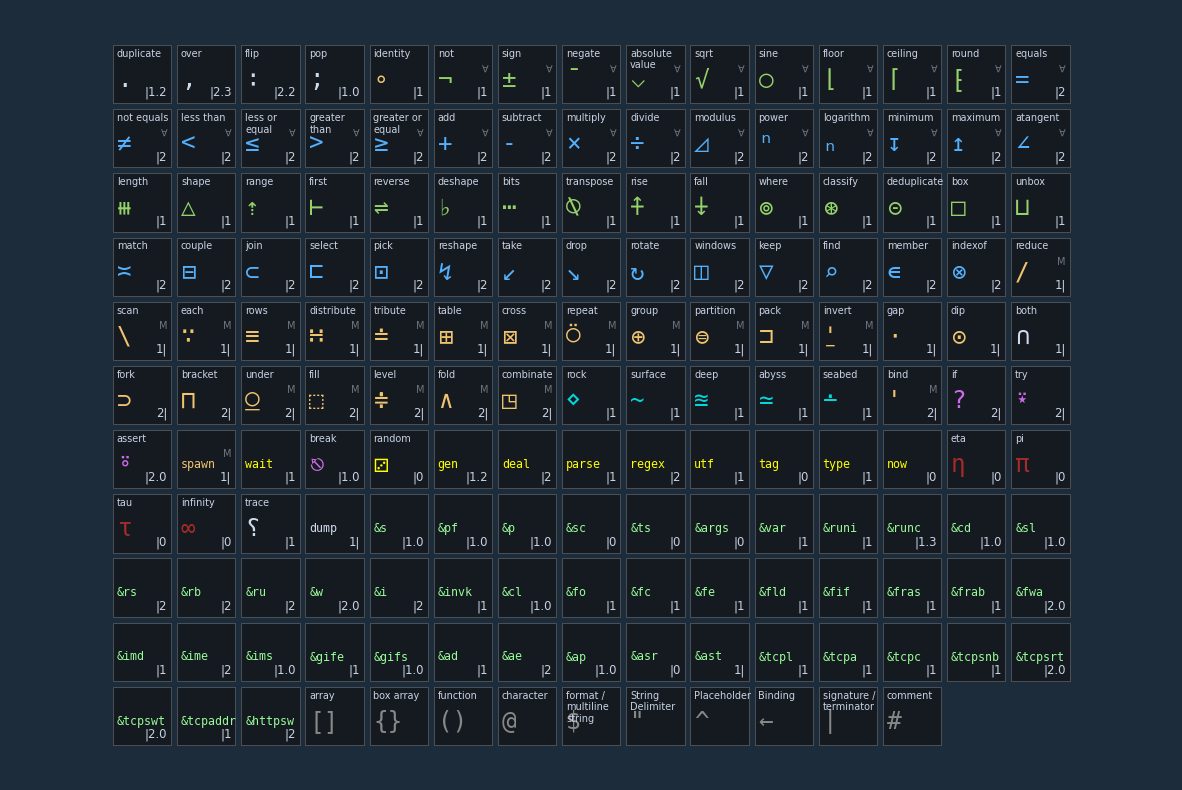

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from typing import Optional
import textwrap

font_properties = fm.FontProperties(family="DejaVu Sans Mono")

def signature(
        stack_input:Optional[int],
        stack_output:Optional[int],
        mod_input:Optional[int],
    ):
    if pd.notna(mod_input):
        return f"{mod_input:.0f}|"
    if stack_output == 1 and pd.notna(stack_input):
        return f"|{stack_input:.0f}"
    if pd.notna(stack_input) and pd.notna(stack_output):
        return f"|{stack_input:.0f}.{stack_output:.0f}"
    return ""

def draw_element(
        ax,
        x:float,
        y:float,
        size:float,
        padding:float,
        font_scale:float,
        glyph:Optional[str],
        glyph_color:str,
        name:str,
        pervasive:str,
        modifier:str,
        stack_input:Optional[int],
        stack_output:Optional[int],
        mod_input:Optional[int],
        foreground_colour:str = "#c8d2e4",
        background_colour:str = "#141a1f",
        outline_colour:str = "#606468",
    ):
    
    
    # Draw a rectangle
    rect = patches.Rectangle(
        (x, y), 50, 50, linewidth=0.5, edgecolor=outline_colour, facecolor=background_colour)
    ax.add_patch(rect)

    if glyph == "" or pd.isna(glyph):
        ax.text(
            x +  padding,
            y + size/5*3, 
            name,
            color=glyph_color,
            fontsize=12*font_scale,
            font_properties=font_properties,
            verticalalignment='center'
        )
    else:
        ax.text(
            x +  padding,
            y + size/5*3, 
            glyph,
            color=glyph_color,
            fontsize=25*font_scale,
            font_properties=font_properties,
            verticalalignment='center'
        )
        ax.text(
            x +  padding,
            y +  padding, 
            textwrap.fill(name, width=11),
            color=foreground_colour,
            fontsize=10*font_scale,
            verticalalignment='top'
        )
    ax.text(
        x + size-padding,
        y + size-padding, 
        signature(stack_input, stack_output, mod_input),
        color=foreground_colour,
        fontsize=12*font_scale,
        verticalalignment='bottom',
        horizontalalignment='right'
    )
    pervasive_indicator_text = ax.text(
        x + size-padding,
        y + size/3, 
        pervasive,
        color=foreground_colour,
        fontsize=10*font_scale,
        verticalalignment='top',
        horizontalalignment='right'
    )
    pervasive_indicator_text.set_alpha(0.5)
    modifier_indicator_text = ax.text(
        x + size-padding,
        y + size/3, 
        modifier,
        color=foreground_colour,
        fontsize=10*font_scale,
        verticalalignment='top',
        horizontalalignment='right'
    )
    modifier_indicator_text.set_alpha(0.5)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_aspect('equal', adjustable='datalim')
fig.set_facecolor("#1d2c3a")
ax.invert_yaxis()
plt.axis('off')

for index,(row_index, row) in enumerate(df.iterrows()):
    draw_element(
        ax,
        x = index%15*55,
        y = index//15*55,
        size=50,
        padding=50/15,
        font_scale=0.7,
        glyph        = row['glyph'],
        glyph_color = row['color_foreground'],
        name         = row['name'],
        pervasive    = row['pervasive'],
        modifier     = row['modifier'],
        stack_input  = row['count_inputs'],
        stack_output = row['count_outputs'],
        mod_input    = row['count_modifier_inputs'],
    )

ax.autoscale_view()
plt.show()